In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/PINN

/content/drive/.shortcut-targets-by-id/1kBpsdlzoY9Dl5Og9N1a-GxSNoIkIrQV4/PINN


In [3]:
!pip install git+https://github.com/RobertJaro/NF2.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/RobertJaro/NF2.git to /tmp/pip-req-build-7k3vb15n
  Running command git clone --filter=blob:none --quiet https://github.com/RobertJaro/NF2.git /tmp/pip-req-build-7k3vb15n
  Resolved https://github.com/RobertJaro/NF2.git to commit cbd3e684d2040d258213cdb9b0372ca177ac5f3a
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.9 MB/s eta 0:00:00
  Created wheel for nf2: filename=nf2-0.2-py3-none-any.whl size=39371 sha256=136b0ff339c309b9d0d639ac0c5de749fdc5a293ef1a061fe746b14d73359989
  Stored in directory: /tmp/pip-ephem-wheel-cache-bxls_y7g/wheels/34/af/f0/ece70a6af02514037626fa92a4eadbbba8f19e7ea134186066
Successfully built nf2


In [4]:
# general imports
import glob
import os
from datetime import datetime
from dateutil.parser import parse
import shutil

# download
import drms
from urllib import request

# data processing
import numpy as np
from astropy.nddata import block_reduce
from sunpy.map import Map

# deep learning
import torch

# NF2
from nf2.train.trainer import NF2Trainer
from nf2.data.download import download_HARP, find_HARP, donwload_ds
from nf2.train.metric import *
from nf2.evaluation.unpack import load_cube
from nf2.evaluation.energy import get_free_mag_energy
from nf2.data.loader import load_hmi_data
from nf2.train.metric import energy

# visualization
from matplotlib import pyplot as plt

In [5]:
jsoc_email = 'mgjeon@khu.ac.kr'
client = drms.Client(email=jsoc_email, verbose=True)

noaa_nums = [11158]
year = 2011
month = 2
day = 12
hour = 0
minute = 0

date = datetime(year, month, day, hour, minute)

sharp_nr = find_HARP(date, noaa_nums, client)
print(sharp_nr)
download_dir = 'AR_377'

377


In [6]:
bin = 2
spatial_norm = 160 
height = 160 
b_norm = 2500  
d_slice = [66, 658, 9, 377] # crop

dim = 256

lambda_div = 0.1 
lambda_ff = 0.1 
iterations = 10e4 
iterations = int(iterations)
decay_iterations = 5e4 
decay_iterations = int(decay_iterations)
batch_size = 1e4 
batch_size = int(batch_size)
log_interval = 1e4 
log_interval = int(log_interval)
validation_interval = 1e4 
validation_interval = int(validation_interval)
potential = True

In [7]:
base_path = './ar_%d_%s' % (sharp_nr, date.isoformat('T'))
series_base_path = './ar_series_%d_%s' % (sharp_nr, date.isoformat('T'))
series_download_dir = './AR_377_series'
bpp = os.path.join(series_base_path, 'base')

In [8]:
nf2_paths = sorted(glob.glob(os.path.join(bpp, '**', 'extrapolation_result.nf2')))

In [9]:
from pathlib import Path

In [10]:
eval_energy_path = Path(os.path.join(series_base_path, 'eval_energy'))
energy_files = [x for x in eval_energy_path.glob('**/*.npy')]
energy_files = sorted(energy_files)

In [12]:
energy_series_dates = [datetime.strptime(os.path.basename(f), '%Y%m%d_%H%M%S_TAI.npy') for f in energy_files]

In [66]:
energys = np.array([np.load(f) for f in energy_files])

In [128]:
cm_per_pixel = 360e5 * bin
dV = cm_per_pixel**3
energys_dV = energys*dV

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime  

In [130]:
csv01 = Path('./author/series_01.csv')
csv1 = Path('./author/series_1.csv')

In [131]:
df01 = pd.read_csv(csv01, index_col=False)
df1 = pd.read_csv(csv1, index_col=False)

In [132]:
author01 = df01[' E (10^33 erg)'][:-1]
author1 = df1[' E (10^33 erg)'][:-1]

In [137]:
dfwb1.keys()

Index(['TIME (10^9 sec since 1-jan-1979 )', ' Ediv/E', ' |Emix|/Ejs',
       ' <theta_J>', ' <|fi|>', ' Cvec(B vs CurlA)', ' Cerg(B vs CurlA)',
       ' Cvec(B0 vs CurlA0)', ' Cerg(B0 vs CurlA0)', ' |phi| (10^22 Mx)',
       ' |Iz| (10^12 A)', ' E (10^33 erg)', ' E0 (10^33 erg)',
       ' Ef (10^33 erg)', ' Hv (10^42 Mx^2)', ' Hpj (10^42 Mx^2)',
       ' Hj (10^42 Mx^2)'],
      dtype='object')

In [145]:
csvwb1 = Path('./author/series_wb1.csv')
dfwb1 = pd.read_csv(csvwb1, index_col=False)
xwb1 = dfwb1['TIME (10^9 sec since 1-jan-1979 )'].map(lambda x: datetime.datetime(1979, 1, 1) + datetime.timedelta(seconds=x*1e9))
authorwb1 = dfwb1[' E (10^33 erg)']

In [143]:
csvwb2 = Path('./author/series_wb2.csv')
dfwb2 = pd.read_csv(csvwb2, index_col=False)
xwb2 = dfwb2['TIME (10^9 sec since 1-jan-1979 )'].map(lambda x: datetime.datetime(1979, 1, 1) + datetime.timedelta(seconds=x*1e9))
authorwb2 = dfwb2[' E (10^33 erg)']

In [133]:
energy_mine = energys_dV/1e33

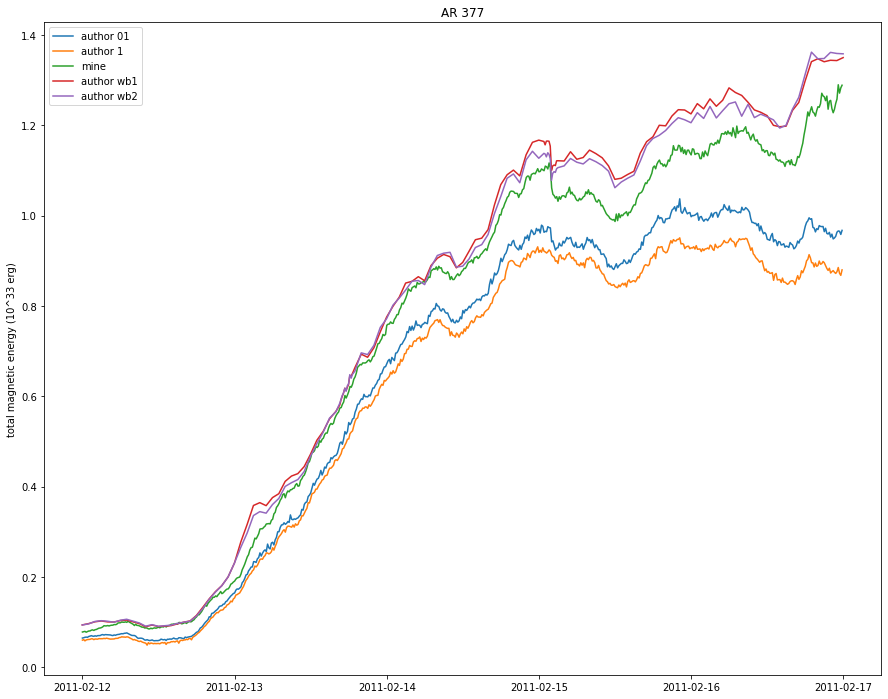

In [160]:
plt.figure(figsize=(15, 12))
plt.plot(energy_series_dates, author01, label='author 01')
plt.plot(energy_series_dates, author1, label='author 1')
plt.plot(energy_series_dates, energy_mine, label='mine')
plt.plot(xwb1, authorwb1, label='author wb1')
plt.plot(xwb2, authorwb2, label='author wb2')
plt.title('AR 377')
plt.ylabel('total magnetic energy (10^33 erg)')
# figure_energy_path = os.path.join(series_base_path, './energy.png')
# plt.savefig(figure_energy_path, dpi=300)
plt.legend()
plt.show()

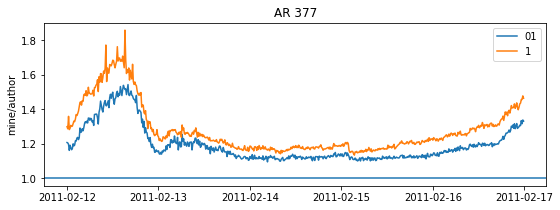

In [159]:
plt.figure(figsize=(9, 3))
plt.plot(energy_series_dates, energy_mine/author01, label='01')
plt.plot(energy_series_dates, energy_mine/author1, label='1')
plt.axhline(1)
plt.title('AR 377')
plt.ylabel('mine/author')
# figure_energy_path = os.path.join(series_base_path, './energy.png')
# plt.savefig(figure_energy_path, dpi=300)
plt.legend()
plt.show()

In [154]:
360/3455

0.10419681620839363